In [1]:
from scipy.spatial.distance import cosine
import numpy as np
import pandas as pd
import seaborn as sns
import h5py
import umap
import hdbscan
import networkx as nx
from node2vec import Node2Vec
from TDAembedding import TDAembedding
import matplotlib.pyplot as plt
from scipy.io import savemat,loadmat
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Load data

Simulated WSBM data (see NetGlowExmpls.ipynb)

In [2]:
data = loadmat("test_matrices/sim_data.mat")

In [3]:
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'AssortD', 'AssortS', 'DissortD', 'DissortS', 'CorePD', 'CorePS', 'OrderedD', 'OrderedS', 'HierarD', 'HierarS', 'DominD', 'DominS'])

# Comparing embedding arised from node2vec and TDA

Dimension reduction was performed with UMAP


### Utils functions 
For node2vec and TDA embedding with drawing in UMAP

In [4]:
n = 16
target = np.array([i // (n // 4) for i in range(n)]) # split the graph evenly

In [5]:
def draw_node2vec(matrix, target,n_neighbors = 8, nettype = "Assortative network example",annotate = False):
    graph = nx.from_numpy_matrix(matrix)
    node2vec = Node2Vec(graph, dimensions=25, walk_length=15, p=0.5,q=1, num_walks=200, workers=4)
    model = node2vec.fit(window=10, min_count=1, batch_words=4)
    nodes = [str(node) for node in range(matrix.shape[0])]
    vecs = []
    for node in nodes:
        vecs.append(model.wv.__getitem__([node]))
    node2vec_ebds = np.squeeze(np.array(vecs))   
    reducer = umap.UMAP(n_neighbors=n_neighbors, metric = 'cosine', n_components=2)
    u_emb = reducer.fit_transform(node2vec_ebds)
    plt.scatter(u_emb[:, 0], u_emb[:, 1], c=target, cmap='viridis', s=25)
    plt.colorbar(boundaries=np.arange(5)-0.5).set_ticks(np.arange(4))
    if annotate:
        for i, txt in enumerate(nodes):
            plt.annotate(txt, (u_emb[i, 0], u_emb[i, 1]))
    plt.gca().set_aspect('equal', 'datalim')
    plt.title(f'UMAP projection of the node2vec embedding: \n{nettype}', fontsize=14);
    plt.savefig('imgs/'+'Node2vec_'.join(nettype.split())+'.png')
    plt.show()
    return u_emb, node2vec_ebds

def find_TDA_embded(path_to_int, num_nodes):
    embd = TDAembedding(path_to_int, num_nodes=num_nodes)
    intervals = embd.read_intervals(h0=True, h1=True)
    df0 = embd.create_h0_embedding(intervals=intervals)
    df1 = embd.create_h1_embedding(intervals=intervals)
    return embd
def draw_TDA_umap(path_to_int, nettype = "Assortative", b1coeff= 0.5, n_neighbors = 4, metric = 'cosine', annotate = False):
    
    emb = find_TDA_embded(path_to_int, num_nodes=len(target))
    df0 = emb.h0embedding
    df1 = b1coeff*emb.h1embedding
    dataF = pd.concat([df0, df1], axis=1).values
    reducer = umap.UMAP(n_neighbors=n_neighbors, metric = 'cosine', n_components=2)
    u_emb = reducer.fit_transform(dataF)
    plt.scatter(u_emb[:, 0], u_emb[:, 1], c=target, cmap='viridis', s=25)
    plt.colorbar(boundaries=np.arange(5)-0.5).set_ticks(np.arange(4))
    nodes = [str(node) for node in range(len(target))]
    if annotate:
        for i, txt in enumerate(nodes):
            plt.annotate(txt, (u_emb[i, 0], u_emb[i, 1]))
    plt.gca().set_aspect('equal', 'datalim')
    
    plt.title(f'UMAP projection of the TDA embedding: \n{nettype}', fontsize=14);
    plt.savefig('imgs/'+'TDA_'.join(nettype.split())+'.png')

    plt.show()
    return u_emb
def get_short(value_short, df1 = None):
    names = list(df1.columns)[:-2]
    short = [i for i,name in enumerate(names) if float(name.split()[0].split('-')[0]) < value_short]
    long= [i for i,name in enumerate(names) if float(name.split()[0].split('-')[0]) >= value_short]

    return short, long

## Assortative network example

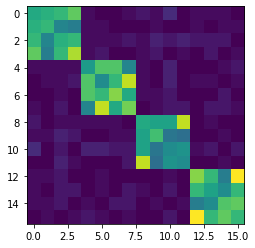

In [6]:
matrix = data['AssortS']
plt.imshow(matrix)
path_to_int = 'ints/ints_assort.txt'

### Node2vec embedding

Computing transition probabilities: 100%|██████████| 16/16 [00:00<00:00, 2120.61it/s]


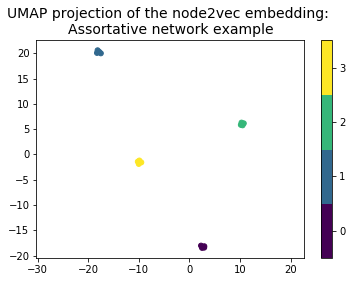

In [7]:
u_emb, node2vec_ebds = draw_node2vec(matrix, target,n_neighbors = 8, nettype = "Assortative network example",annotate = False)

### TDA Embedding

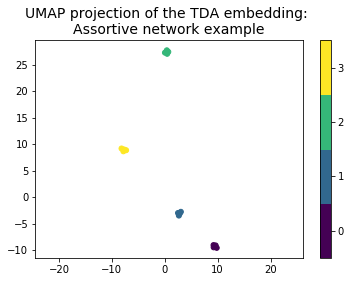

In [8]:
u_emb = draw_TDA_umap(path_to_int,n_neighbors = 4, nettype = "Assortive network example")

## Dissortative network example

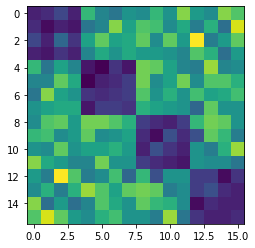

In [9]:
matrix = data['DissortS']
path_to_int = 'ints/ints_dissort.txt'
plt.imshow(matrix)

### Node2vec embedding

Computing transition probabilities: 100%|██████████| 16/16 [00:00<00:00, 1210.22it/s]


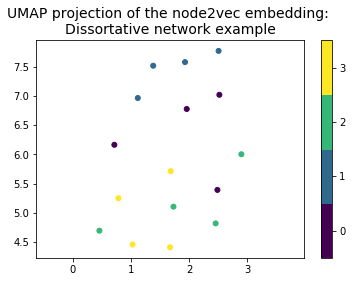

In [10]:
u_emb, node2vec_ebds = draw_node2vec(matrix, target,n_neighbors = 8, nettype = "Dissortative network example",annotate = False)

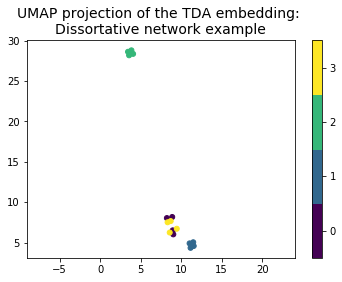

In [11]:
u_emb = draw_TDA_umap(path_to_int, b1coeff = 0.3, n_neighbors = 5, nettype = "Dissortative network example")

##  Core-periphery network example

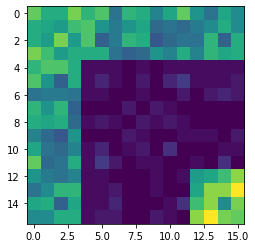

In [12]:
matrix = data['CorePS']
path_to_int = 'ints/ints_core.txt'
plt.imshow(matrix)

Computing transition probabilities: 100%|██████████| 16/16 [00:00<00:00, 1731.04it/s]


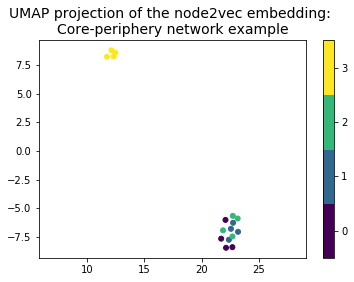

In [13]:
u_emb, node2vec_ebds = draw_node2vec(matrix, target,n_neighbors = 8, nettype = "Core-periphery network example",annotate = False)

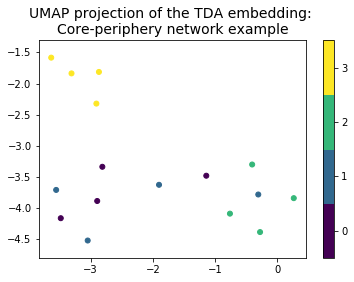

In [14]:
u_emb = draw_TDA_umap(path_to_int, b1coeff = 1.1, n_neighbors = 5, nettype = "Core-periphery network example")

## Ordered

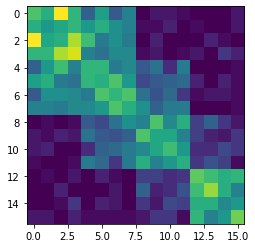

In [15]:
matrix = data['OrderedS']
path_to_int = 'ints/ints_ordered.txt'
plt.imshow(matrix)

Computing transition probabilities: 100%|██████████| 16/16 [00:00<00:00, 1601.22it/s]


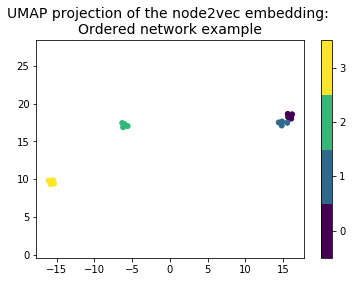

In [16]:
u_emb, node2vec_ebds = draw_node2vec(matrix, target,n_neighbors = 8, nettype = "Ordered network example",annotate = False)

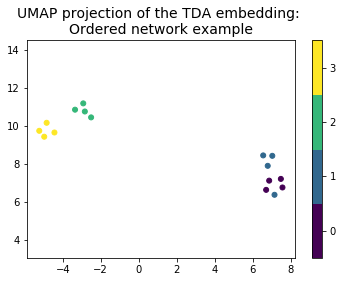

In [17]:
u_emb = draw_TDA_umap(path_to_int, b1coeff = 0.8, n_neighbors = 5, nettype = "Ordered network example")

## Hierarhical structure


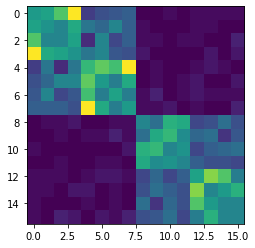

In [18]:
matrix = data['HierarS']
path_to_int = 'ints/ints_hierarhical.txt'
plt.imshow(matrix)

Computing transition probabilities: 100%|██████████| 16/16 [00:00<00:00, 1900.72it/s]


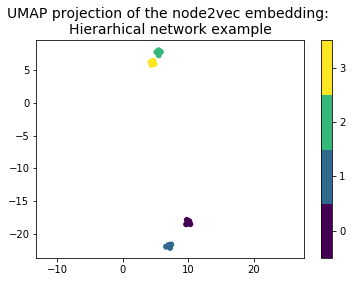

In [19]:
u_emb, node2vec_ebds = draw_node2vec(matrix, target,n_neighbors = 6, nettype = "Hierarhical network example",annotate = False)

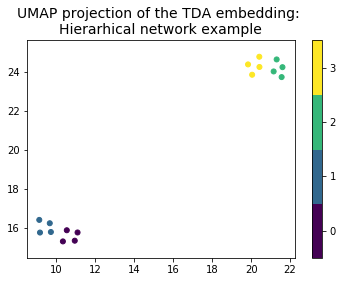

In [20]:
u_emb = draw_TDA_umap(path_to_int, b1coeff = 0.5, n_neighbors = 6, nettype = "Hierarhical network example")

## One dominant block

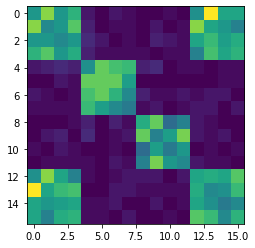

In [21]:
matrix = data['DominS']
path_to_int = 'ints/ints_dominant.txt'
plt.imshow(matrix)

Computing transition probabilities: 100%|██████████| 16/16 [00:00<00:00, 1730.99it/s]


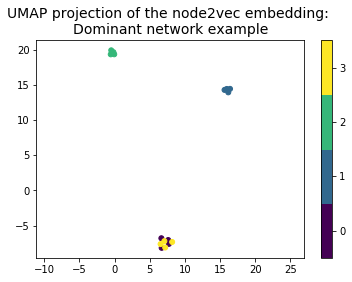

In [22]:
u_emb, node2vec_ebds = draw_node2vec(matrix, target,n_neighbors = 6, nettype = "Dominant network example",annotate = False)

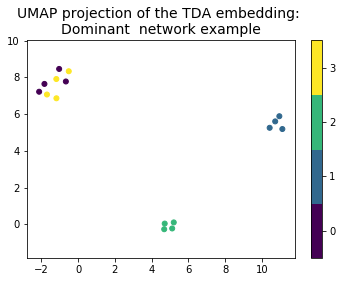

In [23]:
u_emb = draw_TDA_umap(path_to_int, b1coeff = 0.5, n_neighbors = 5, nettype = "Dominant  network example")